In [41]:
import pandas as pd
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ast
import json
import pandas as pd
import wandb
import re

In [3]:

# A dictionary mapping single-letter codes to descriptive names
feature_map = {
    'c': 'co-expression',
    'd': 'domain similarity',
    'g': 'GO semantic similarity',
    'p': 'pathway co-occurrence',
    's': 'sequence similarity'
}

def decode_relations(feature_str):
    """
    1) Split on '_' and take the second piece (index 1).
    2) If 'shuffled' appears in that piece, return 'Shuffled'.
    3) Otherwise, decode each single-letter code.
    """
    parts = feature_str.split('_')
    if len(parts) < 2:
        # If there's no second piece, just return the original string
        return feature_str
    
    second_piece = parts[1]
    
    # Decode single-letter codes
    decoded = []
    for char in second_piece.lower():
        if char in feature_map:
            decoded.append(feature_map[char])

    decoded.append('PPI')
    
    # Join the decoded feature names, or return the second piece if none matched
    return ', '.join(decoded) if decoded else second_piece

def decode_features(feature_str):
    """
    Decode the feature names in a DataFrame.
    """
    parts = feature_str.split('_')
    if len(parts) < 2:
        # If there's no second piece, just return the original string
        return 'multi-omics'
    
    third_piece = parts[2] if len(parts) > 2 else ''
    
    # Check for "shuffled" (case-insensitive)
    if 'shuffled' in third_piece.lower():
        return 'shuffled features'
    else:
        return 'multi-omics'

In [4]:
# 1. Read CSV file into a pandas DataFrame
#    Replace 'results.csv' with your actual CSV filename.
df = pd.read_csv("../results/wand_results_25.03.20.csv")

# 1.1. Rename columns from test_aupr, test_auroc, test_acc, test_f1 to AUPR, AUROC, ACC, F1
rename_dict = {
    'test_aupr': 'AUPR',
    'test_auc': 'AUROC',
    'test_accuracy': 'ACC',
    'test_f1': 'F1'
}

df.rename(columns=rename_dict, inplace=True)
df.dropna(subset=['AUPR', 'AUROC', 'ACC', 'F1'], inplace=True)

In [5]:
# 2. Filter rows so we only keep those where the Dataset name starts with "CPDB"
df_filtered = df[df["Name"].str.startswith("CPDB")]
df_filtered = df_filtered[df_filtered["Name"].str.contains("nh_32") == False]

In [6]:
# 3. Decode the features column
df_filtered["Relations"] = df_filtered["Name"].apply(decode_relations)
df_filtered["Features"] = df_filtered["Name"].apply(decode_features)

In [7]:
# 4. Group by (Dataset, Features) to aggregate multiple runs (mean and standard deviation)
agg_df = (
    df_filtered
    .groupby(["Name", "Relations", "Features"], as_index=False)
    .agg({
        "AUPR": ["mean", "std"],
        "AUROC": ["mean", "std"],
        "ACC": ["mean", "std"],
        "F1": ["mean", "std"],
    })
)

In [8]:
# Flatten the multi-index columns produced by aggregation
agg_df.columns = [
    "Dataset", 
    "Relations", 
    "Features",
    "AUPR_mean", "AUPR_std", 
    "AUROC_mean", "AUROC_std", 
    "ACC_mean", "ACC_std", 
    "F1_mean", "F1_std"
]


In [9]:
# 5. Format the metrics as "mean ± std"
def fmt_mean_std(mean_col, std_col, df, decimals=3):
    return (
        df[mean_col].round(decimals).astype(str)
        + " ± "
        + df[std_col].round(decimals).astype(str)
    )

agg_df["AUPR"] = fmt_mean_std("AUPR_mean", "AUPR_std", agg_df)
agg_df["AUROC"] = fmt_mean_std("AUROC_mean", "AUROC_std", agg_df)
agg_df["ACC"] = fmt_mean_std("ACC_mean", "ACC_std", agg_df)
agg_df["F1"] = fmt_mean_std("F1_mean", "F1_std", agg_df)


In [10]:
# 6. Select only the final columns for display
final_df = agg_df[["Relations","Features", "AUPR", "AUROC", "ACC", "F1"]]

# 7. Print the resulting table as Markdown
print(final_df.to_markdown(index=False))

| Relations                                                                                                 | Features          | AUPR          | AUROC         | ACC           | F1            |
|:----------------------------------------------------------------------------------------------------------|:------------------|:--------------|:--------------|:--------------|:--------------|
| co-expression, PPI                                                                                        | multi-omics       | 0.813 ± 0.004 | 0.871 ± 0.014 | 0.808 ± 0.012 | 0.821 ± 0.013 |
| co-expression, domain similarity, PPI                                                                     | multi-omics       | 0.822 ± 0.01  | 0.871 ± 0.01  | 0.799 ± 0.037 | 0.81 ± 0.027  |
| co-expression, domain similarity, GO semantic similarity, PPI                                             | multi-omics       | 0.898 ± 0.022 | 0.919 ± 0.01  | 0.856 ± 0.009 | 0.862 ± 0.007 |
| co-expression, domain simila

In [11]:
final_df

,Relations,Features,AUPR,AUROC,ACC,F1
0,"co-expression, PPI",multi-omics,0.813 ± 0.004,0.871 ± 0.014,0.808 ± 0.012,0.821 ± 0.013
1,"co-expression, domain similarity, PPI",multi-omics,0.822 ± 0.01,0.871 ± 0.01,0.799 ± 0.037,0.81 ± 0.027
2,"co-expression, domain similarity, GO semantic ...",multi-omics,0.898 ± 0.022,0.919 ± 0.01,0.856 ± 0.009,0.862 ± 0.007
3,"co-expression, domain similarity, GO semantic ...",multi-omics,0.919 ± 0.007,0.925 ± 0.014,0.907 ± 0.005,0.909 ± 0.005
4,"co-expression, domain similarity, GO semantic ...",multi-omics,0.917 ± 0.013,0.926 ± 0.012,0.891 ± 0.02,0.895 ± 0.02
5,"co-expression, domain similarity, GO semantic ...",shuffled features,0.863 ± 0.03,0.892 ± 0.013,0.87 ± 0.022,0.869 ± 0.025
6,"co-expression, domain similarity, GO semantic ...",multi-omics,0.889 ± 0.013,0.904 ± 0.014,0.862 ± 0.014,0.868 ± 0.012
7,"co-expression, domain similarity, pathway co-o...",multi-omics,0.871 ± 0.017,0.907 ± 0.003,0.883 ± 0.005,0.887 ± 0.003
8,"co-expression, domain similarity, pathway co-o...",multi-omics,0.87 ± 0.031,0.898 ± 0.01,0.875 ± 0.02,0.877 ± 0.02
9,"co-expression, domain similarity, sequence sim...",multi-omics,0.822 ± 0.009,0.866 ± 0.013,0.799 ± 0.012,0.805 ± 0.016


In [12]:
# Function to extract the mean value from a "mean ± std" string
def extract_mean(cell):
    try:
        return float(cell.split(" ± ")[0])
    except Exception:
        return 0

# Create a numeric DataFrame for the metric columns by extracting the mean values
numeric_df = final_df[["AUPR", "AUROC", "ACC", "F1"]].map(extract_mean)

# Updated function to compute a background color with adjustable transparency
def heatmap_color(val, vmin, vmax, cmap='YlGnBu', alpha=0.5):
    # Normalize the value between 0 and 1
    norm = (val - vmin) / (vmax - vmin) if vmax > vmin else 0.5
    rgba = matplotlib.colormaps.get_cmap(cmap)(norm)
    # Override the alpha value with our desired transparency
    r, g, b, _ = rgba
    # Return a CSS rgba color string; note alpha is a float between 0 and 1
    return f'background-color: rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {alpha})'

# Function to style a column using its numeric version
def style_column(series, numeric_series, cmap='YlGnBu', alpha=0.5):
    vmin, vmax = numeric_series.min(), numeric_series.max()
    return [heatmap_color(val, vmin, vmax, cmap, alpha) for val in numeric_series]

# Apply the style to each of the metric columns using the numeric DataFrame for colors.
styled = final_df.style.apply(
    lambda col: style_column(col, numeric_df[col.name]) if col.name in ["AUPR", "AUROC", "ACC", "F1"] else ['']*len(col),
    subset=["AUPR", "AUROC", "ACC", "F1"]
)

# In a Jupyter Notebook, simply display the styled DataFrame:
styled

,Relations,Features,AUPR,AUROC,ACC,F1
0,"co-expression, PPI",multi-omics,0.813 ± 0.004,0.871 ± 0.014,0.808 ± 0.012,0.821 ± 0.013
1,"co-expression, domain similarity, PPI",multi-omics,0.822 ± 0.01,0.871 ± 0.01,0.799 ± 0.037,0.81 ± 0.027
2,"co-expression, domain similarity, GO semantic similarity, PPI",multi-omics,0.898 ± 0.022,0.919 ± 0.01,0.856 ± 0.009,0.862 ± 0.007
3,"co-expression, domain similarity, GO semantic similarity, pathway co-occurrence, PPI",multi-omics,0.919 ± 0.007,0.925 ± 0.014,0.907 ± 0.005,0.909 ± 0.005
4,"co-expression, domain similarity, GO semantic similarity, pathway co-occurrence, sequence similarity, PPI",multi-omics,0.917 ± 0.013,0.926 ± 0.012,0.891 ± 0.02,0.895 ± 0.02
5,"co-expression, domain similarity, GO semantic similarity, pathway co-occurrence, sequence similarity, PPI",shuffled features,0.863 ± 0.03,0.892 ± 0.013,0.87 ± 0.022,0.869 ± 0.025
6,"co-expression, domain similarity, GO semantic similarity, sequence similarity, PPI",multi-omics,0.889 ± 0.013,0.904 ± 0.014,0.862 ± 0.014,0.868 ± 0.012
7,"co-expression, domain similarity, pathway co-occurrence, PPI",multi-omics,0.871 ± 0.017,0.907 ± 0.003,0.883 ± 0.005,0.887 ± 0.003
8,"co-expression, domain similarity, pathway co-occurrence, sequence similarity, PPI",multi-omics,0.87 ± 0.031,0.898 ± 0.01,0.875 ± 0.02,0.877 ± 0.02
9,"co-expression, domain similarity, sequence similarity, PPI",multi-omics,0.822 ± 0.009,0.866 ± 0.013,0.799 ± 0.012,0.805 ± 0.016


/var/folders/fh/dk_7wcx551n03dv4ztv1_d740000gp/T/ipykernel_34791/2543446060.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


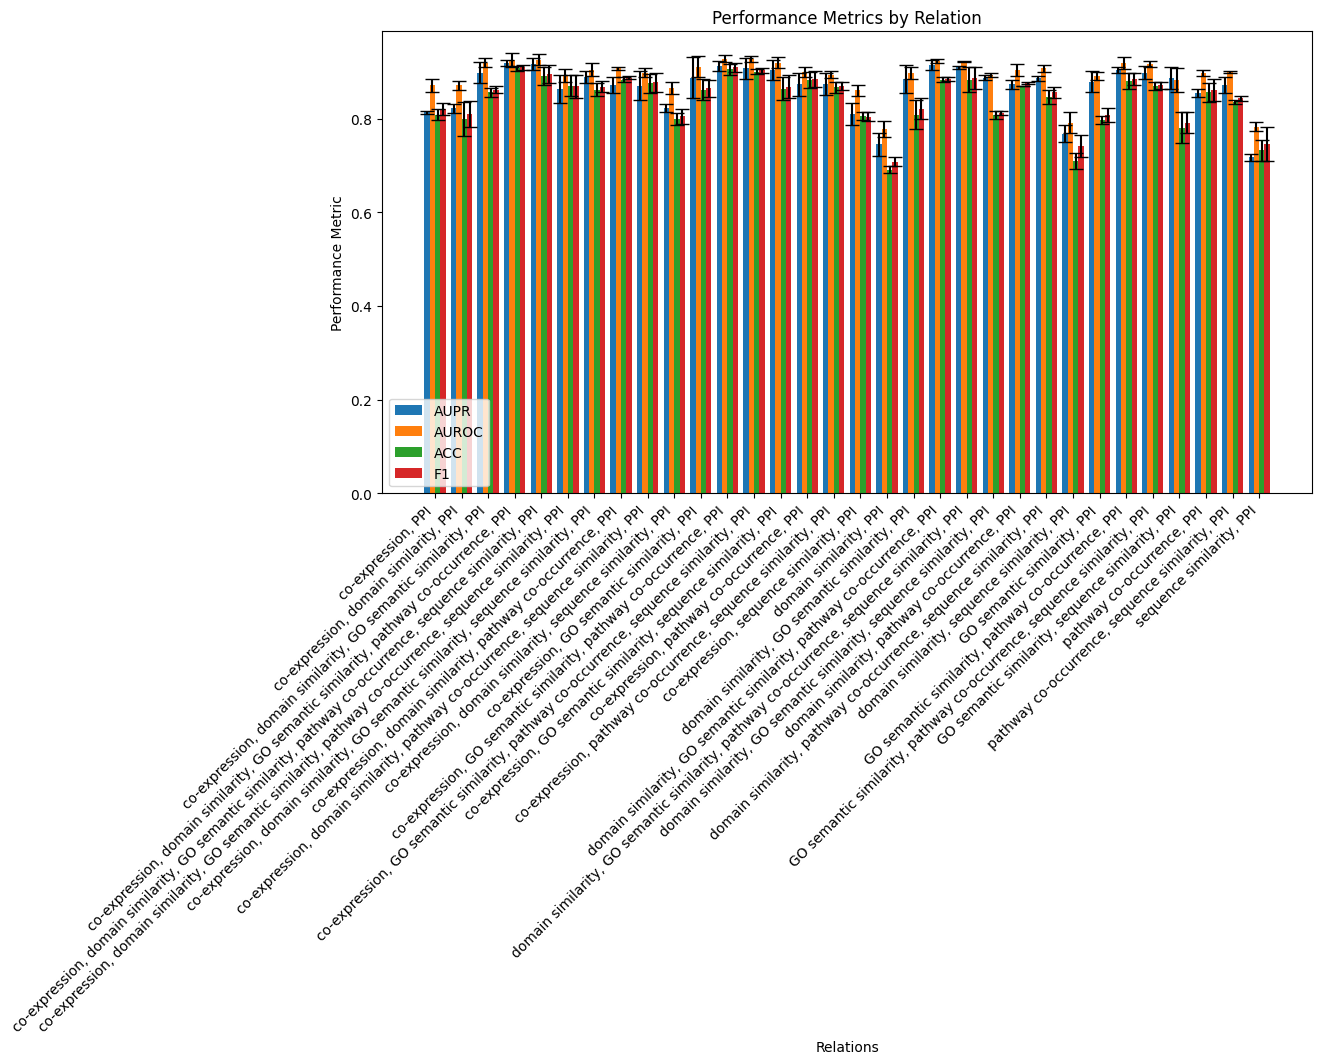

In [13]:

# Function to parse "mean ± std" strings into floats
def parse_metric(metric_str):
    mean_str, std_str = metric_str.split(" ± ")
    return float(mean_str), float(std_str)

# Extract metrics into separate lists
relations = final_df["Relations"].tolist()
AUPR_means, AUPR_stds = zip(*final_df["AUPR"].apply(parse_metric))
AUROC_means, AUROC_stds = zip(*final_df["AUROC"].apply(parse_metric))
ACC_means, ACC_stds = zip(*final_df["ACC"].apply(parse_metric))
F1_means, F1_stds = zip(*final_df["F1"].apply(parse_metric))

# Number of groups and bar settings
n_groups = len(relations)
index = np.arange(n_groups)
bar_width = 0.2

plt.figure(figsize=(12, 6))

# Create bars for each metric with error bars
plt.bar(index, AUPR_means, bar_width, yerr=AUPR_stds, capsize=5, label='AUPR')
plt.bar(index + bar_width, AUROC_means, bar_width, yerr=AUROC_stds, capsize=5, label='AUROC')
plt.bar(index + 2*bar_width, ACC_means, bar_width, yerr=ACC_stds, capsize=5, label='ACC')
plt.bar(index + 3*bar_width, F1_means, bar_width, yerr=F1_stds, capsize=5, label='F1')

plt.xlabel('Relations')
plt.ylabel('Performance Metric')
plt.title('Performance Metrics by Relation')
plt.xticks(index + 1.5*bar_width, relations, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

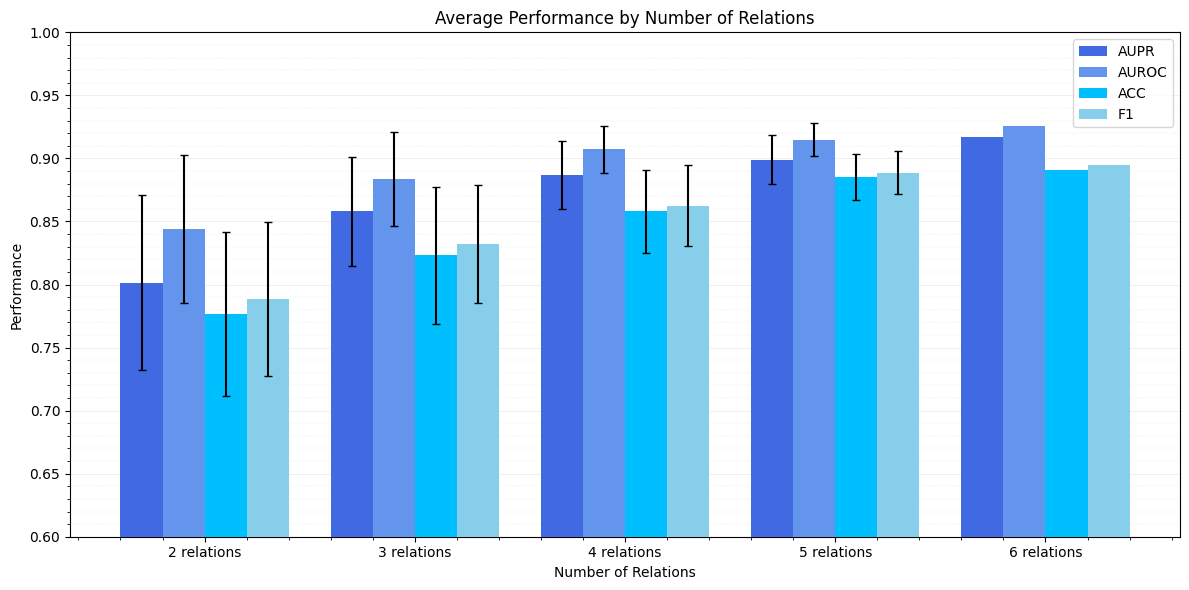

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Exclude rows with "shuffled features"
df_filtered = final_df[final_df["Features"].str.lower() != "shuffled features"].copy()

# 2. Create a new column that counts the number of relations 
# (count items from splitting the "Relations" column by commas)
df_filtered["n_relations"] = df_filtered["Relations"].apply(lambda x: len(x.split(',')))

# 3. Create new numeric columns by extracting the mean and std from the "mean ± std" strings.
for metric in ["AUPR", "AUROC", "ACC", "F1"]:
    df_filtered[f"{metric}_mean"] = df_filtered[metric].apply(lambda x: float(x.split(" ± ")[0]))
    df_filtered[f"{metric}_std"]  = df_filtered[metric].apply(lambda x: float(x.split(" ± ")[1]))

# 4. Group by the number of relations and aggregate: compute the mean of the means,
# and also compute the standard deviation across these mean values (to show variability across different relation types)
grouped = df_filtered.groupby("n_relations").agg({
    "AUPR_mean": ['mean', 'std'],
    "AUROC_mean": ['mean', 'std'],
    "ACC_mean": ['mean', 'std'],
    "F1_mean":   ['mean', 'std']
}).reset_index()

# Flatten the multi-level columns
grouped.columns = ['n_relations', 
                   'AUPR_mean', 'AUPR_std', 
                   'AUROC_mean', 'AUROC_std', 
                   'ACC_mean', 'ACC_std', 
                   'F1_mean', 'F1_std']

# 5. Create labels for the x-axis
grouped["label"] = grouped["n_relations"].apply(lambda x: f"{x} relations")

# 6. Plot the grouped bar chart with error bars for each metric
n_groups = len(grouped)
index = np.arange(n_groups)
bar_width = 0.2

plt.figure(figsize=(12, 6))

plt.bar(index, grouped["AUPR_mean"], bar_width, yerr=grouped["AUPR_std"], capsize=3, label="AUPR", color = 'royalblue', zorder=3)
plt.bar(index + bar_width, grouped["AUROC_mean"], bar_width, yerr=grouped["AUROC_std"], capsize=3, label="AUROC", color = 'cornflowerblue', zorder=3)
plt.bar(index + 2*bar_width, grouped["ACC_mean"], bar_width, yerr=grouped["ACC_std"], capsize=3, label="ACC", color = 'deepskyblue', zorder=3)
plt.bar(index + 3*bar_width, grouped["F1_mean"], bar_width, yerr=grouped["F1_std"], capsize=3, label="F1", color = 'skyblue', zorder=3)

plt.grid(axis='y', alpha=0.5, lw=0.5, color='lightgrey', zorder= 0)
plt.minorticks_on()
plt.grid(which='minor', axis='y', alpha=0.5, lw=0.25, linestyle = '--', color='lightgrey', zorder=0)
plt.ylim(0.6,1 )
plt.xlabel("Number of Relations")
plt.ylabel("Performance")
plt.title("Average Performance by Number of Relations")
plt.xticks(index + 1.5*bar_width, grouped["label"])
plt.legend()
plt.tight_layout()
plt.savefig('../figures/average_performance_by_number_of_relations.png', dpi=300)
plt.show()

In [3]:

api = wandb.Api()
entity, project = "aidd_m", "MORGaN"
runs = api.runs(entity + "/" + project)

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains output keys/values for
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    #config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame(
    {"summary": summary_list, 
     #"config": config_list, 
     "name": name_list}
)

runs_df.to_csv("MORGaN_runs.csv")


In [45]:
# Step 1: Extract clean group name (remove seed and iter)
def extract_group_name(name):
    return re.sub(r'_seed_\d+_iter_\d+', '', name)

runs_df['group_name'] = runs_df['name'].apply(extract_group_name)

# Step 2: Extract run type (same as before)
def extract_run_type(name):
    if 'edge_ablations' in name:
        return 'edge_ablations'
    elif 'feature_ablations' in name:
        return 'feature_ablations'
    elif 'ppi_comparison' in name:
        return 'ppi_comparison'
    else:
        return 'other'

runs_df['run_type'] = runs_df['name'].apply(extract_run_type)

# Step 3: Extract relevant metrics from the summary
for metric in ['test_estp_aupr', 'test_estp_auc', 'test_estp_accuracy', 'test_estp_f1']:
    runs_df[metric] = runs_df['summary'].apply(lambda x: x.get(metric, np.nan))

# Step 4: Group by run_type and cleaned group_name
grouped = runs_df.groupby(['run_type', 'group_name'])

# Step 5: Aggregate mean ± std
def aggregate_metrics(df):
    return pd.Series({
        'AUPR': f"{df['test_estp_aupr'].mean():.3f} ± {df['test_estp_aupr'].std():.3f}",
        'AUC': f"{df['test_estp_auc'].mean():.3f} ± {df['test_estp_auc'].std():.3f}",
        'Accuracy': f"{df['test_estp_accuracy'].mean():.3f} ± {df['test_estp_accuracy'].std():.3f}",
        'F1': f"{df['test_estp_f1'].mean():.3f} ± {df['test_estp_f1'].std():.3f}",
    })

summary_df = grouped.apply(aggregate_metrics).reset_index()

# Step 6: Split into separate tables
edge_table = summary_df[summary_df['run_type'] == 'edge_ablations'].drop(columns='run_type')
feature_table = summary_df[summary_df['run_type'] == 'feature_ablations'].drop(columns='run_type')
ppi_table = summary_df[summary_df['run_type'] == 'ppi_comparison'].drop(columns='run_type')

/var/folders/fh/dk_7wcx551n03dv4ztv1_d740000gp/T/ipykernel_30124/2154524734.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = grouped.apply(aggregate_metrics).reset_index()


### Edge ablations

In [55]:
# Define mapping of keywords to relation types
relation_map = {
    'ppi': 'PPI',
    'coexpression': 'Coexpression',
    'sequence': 'Sequence Similarity',
    'domain': 'Domain Similarity',
    'GO': 'GO Semantic Similarity',
    'pathway': 'Pathway Co-occurrence'
}

# Function to extract readable relation types
def extract_relation_types(name):
    excluded_ppi = 'noppi' in name
    randomized = 'random' in name

    included = []
    for key, rel in relation_map.items():
        if key in name:
            if key == 'ppi' and excluded_ppi:
                continue
            included.append(rel)

    # Add 'PPI' explicitly if not excluded and not already caught
    if not excluded_ppi and 'ppi' not in name and 'PPI' not in included:
        included.append('PPI')

    label = ' + '.join(sorted(included)) if included else 'None'
    if randomized:
        label += ' (Randomized)'
    return label

# Apply and update edge_table
edge_table['Relations'] = edge_table['group_name'].apply(extract_relation_types)
edge_table = edge_table[['Relations', 'AUPR', 'AUC', 'Accuracy', 'F1']]

In [56]:
# Randomized runs → new table
random_edge_table = edge_table[edge_table['Relations'].str.contains('Randomized')].copy()

# Non-randomized runs → main edge table
edge_table = edge_table[~edge_table['Relations'].str.contains('Randomized')].copy()

In [57]:
# Helper to count number of relations
def count_relations(rel_string):
    return len(rel_string.replace(' (Randomized)', '').split(' + '))

# Sort edge_table
edge_table['num_relations'] = edge_table['Relations'].apply(count_relations)
edge_table = edge_table.sort_values(by=['num_relations', 'Relations']).drop(columns='num_relations')

# Sort random_edge_table
random_edge_table['num_relations'] = random_edge_table['Relations'].apply(count_relations)
random_edge_table = random_edge_table.sort_values(by=['num_relations', 'Relations']).drop(columns='num_relations')

In [58]:
edge_table.to_csv('../paper/tables/edge_ablations.csv', index=False)
random_edge_table.to_csv('../paper/tables/randomized_edge_ablations.csv', index=False)

In [59]:
edge_table

,Relations,AUPR,AUC,Accuracy,F1
88,Coexpression,0.788 ± 0.006,0.788 ± 0.003,0.805 ± 0.000,0.782 ± 0.000
104,Domain Similarity,0.764 ± 0.000,0.533 ± 0.000,0.537 ± 0.000,0.123 ± 0.000
56,GO Semantic Similarity,0.883 ± 0.002,0.819 ± 0.001,0.805 ± 0.000,0.778 ± 0.000
112,Pathway Co-occurrence,0.863 ± 0.008,0.847 ± 0.004,0.843 ± 0.004,0.832 ± 0.005
116,Sequence Similarity,0.752 ± 0.000,0.508 ± 0.000,0.512 ± 0.000,0.032 ± 0.000
...,...,...,...,...,...
75,Coexpression + Domain Similarity + GO Semantic...,0.891 ± 0.002,0.918 ± 0.001,0.917 ± 0.004,0.918 ± 0.004
27,Coexpression + Domain Similarity + PPI + Pathw...,0.878 ± 0.010,0.906 ± 0.011,0.894 ± 0.020,0.897 ± 0.018
11,Coexpression + GO Semantic Similarity + PPI + ...,0.886 ± 0.007,0.910 ± 0.006,0.913 ± 0.004,0.915 ± 0.004
43,Domain Similarity + GO Semantic Similarity + P...,0.899 ± 0.010,0.896 ± 0.021,0.896 ± 0.004,0.897 ± 0.004


In [65]:
plot_df

,Relations,AUPR,AUC,Accuracy,F1,n_relations,AUPR_mean,AUPR_std,AUC_mean,AUC_std,Accuracy_mean,Accuracy_std,F1_mean,F1_std
88,Coexpression,0.788 ± 0.006,0.788 ± 0.003,0.805 ± 0.000,0.782 ± 0.000,1,0.788,0.006,0.788,0.003,0.805,0.000,0.782,0.000
104,Domain Similarity,0.764 ± 0.000,0.533 ± 0.000,0.537 ± 0.000,0.123 ± 0.000,1,0.764,0.000,0.533,0.000,0.537,0.000,0.123,0.000
56,GO Semantic Similarity,0.883 ± 0.002,0.819 ± 0.001,0.805 ± 0.000,0.778 ± 0.000,1,0.883,0.002,0.819,0.001,0.805,0.000,0.778,0.000
112,Pathway Co-occurrence,0.863 ± 0.008,0.847 ± 0.004,0.843 ± 0.004,0.832 ± 0.005,1,0.863,0.008,0.847,0.004,0.843,0.004,0.832,0.005
116,Sequence Similarity,0.752 ± 0.000,0.508 ± 0.000,0.512 ± 0.000,0.032 ± 0.000,1,0.752,0.000,0.508,0.000,0.512,0.000,0.032,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Coexpression + Domain Similarity + GO Semantic...,0.891 ± 0.002,0.918 ± 0.001,0.917 ± 0.004,0.918 ± 0.004,5,0.891,0.002,0.918,0.001,0.917,0.004,0.918,0.004
27,Coexpression + Domain Similarity + PPI + Pathw...,0.878 ± 0.010,0.906 ± 0.011,0.894 ± 0.020,0.897 ± 0.018,5,0.878,0.010,0.906,0.011,0.894,0.020,0.897,0.018
11,Coexpression + GO Semantic Similarity + PPI + ...,0.886 ± 0.007,0.910 ± 0.006,0.913 ± 0.004,0.915 ± 0.004,5,0.886,0.007,0.910,0.006,0.913,0.004,0.915,0.004
43,Domain Similarity + GO Semantic Similarity + P...,0.899 ± 0.010,0.896 ± 0.021,0.896 ± 0.004,0.897 ± 0.004,5,0.899,0.010,0.896,0.021,0.896,0.004,0.897,0.004


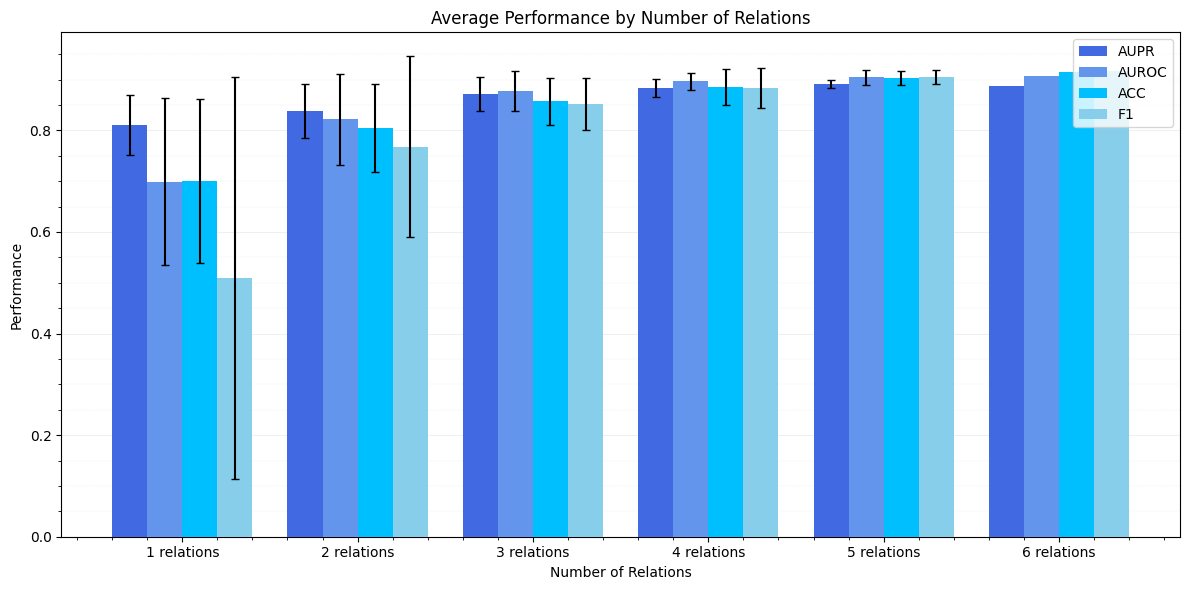

In [68]:
# make a working copy
plot_df = edge_table.copy()

# split “mean ± std” into two floats
for col in ['AUPR','AUC','Accuracy','F1']:
    plot_df[[f'{col}_mean', f'{col}_std']] = (
        plot_df[col]
        .str.split(r'\s*±\s*', expand=True)
        .astype(float)
    )

# now you have numeric *_mean and *_std columns
# count relations as before
plot_df['n_relations'] = plot_df['Relations'].apply(lambda x: len(x.split(' + ')))

# group by n_relations, taking the mean of the means and the std of the means

grouped = (
    plot_df
      .groupby('n_relations')
      .agg(
        AUPR_mean  = ('AUPR_mean',    'mean'),
        AUPR_std   = ('AUPR_mean',    'std'),
        AUROC_mean = ('AUC_mean',     'mean'),
        AUROC_std  = ('AUC_mean',     'std'),
        ACC_mean   = ('Accuracy_mean','mean'),
        ACC_std    = ('Accuracy_mean','std'),
        F1_mean    = ('F1_mean',      'mean'),
        F1_std     = ('F1_mean',      'std'),
      )
      .reset_index()
)


# 5. Create labels for the x-axis
grouped["label"] = grouped["n_relations"].apply(lambda x: f"{x} relations")

# 6. Plot the grouped bar chart with error bars for each metric
n_groups = len(grouped)
index = np.arange(n_groups)
bar_width = 0.2

plt.figure(figsize=(12, 6))

plt.bar(index, grouped["AUPR_mean"], bar_width, yerr=grouped["AUPR_std"], capsize=3, label="AUPR", color = 'royalblue', zorder=3)
plt.bar(index + bar_width, grouped["AUROC_mean"], bar_width, yerr=grouped["AUROC_std"], capsize=3, label="AUROC", color = 'cornflowerblue', zorder=3)
plt.bar(index + 2*bar_width, grouped["ACC_mean"], bar_width, yerr=grouped["ACC_std"], capsize=3, label="ACC", color = 'deepskyblue', zorder=3)
plt.bar(index + 3*bar_width, grouped["F1_mean"], bar_width, yerr=grouped["F1_std"], capsize=3, label="F1", color = 'skyblue', zorder=3)

plt.grid(axis='y', alpha=0.5, lw=0.5, color='lightgrey', zorder= 0)
plt.minorticks_on()
plt.grid(which='minor', axis='y', alpha=0.5, lw=0.25, linestyle = '--', color='lightgrey', zorder=0)
#plt.ylim(0.6,1 )
plt.xlabel("Number of Relations")
plt.ylabel("Performance")
plt.title("Average Performance by Number of Relations")
plt.xticks(index + 1.5*bar_width, grouped["label"])
plt.legend()
plt.tight_layout()
plt.savefig('../paper/figures/average_performance_by_number_of_relations.png', dpi=300)
plt.show()

## Feature ablations

In [48]:

# 1. Define mapping from name‐abbreviation → full feature name
feature_map = {
    'mf':  'Mutation Frequency',
    'ge':  'Gene Expression',
    'cna': 'Copy Number Alterations',
    'meth':'Methylation'
}

# 2. Function to pull out which features are present in the run name
def extract_features(name):
    name_l = name.lower()
    included = []
    for abbr, full in feature_map.items():
        if abbr in name_l:
            included.append(full)
    return ' + '.join(sorted(included)) if included else 'None'

# 3. Apply it to your feature_table (which has columns: name, AUPR, AUC, Accuracy, F1)
feature_table['Features'] = feature_table['group_name'].apply(extract_features)

# 4. Sort by number of features (1, 2, 3, …) and then alphabetically
feature_table['num_features'] = feature_table['Features'].apply(lambda s: len(s.split(' + ')))
feature_table = feature_table.sort_values(['num_features', 'Features']).drop(columns='num_features')

# 5. Keep only the final columns
feature_table = feature_table[['Features', 'AUPR', 'AUC', 'Accuracy', 'F1']]

In [51]:
feature_table.to_csv('../paper/tables/feature_ablations.csv', index=False)

### PPI comparison

In [52]:
ppi_table.to_csv('../paper/tables/ppi_comparison.csv', index=False)